# 2D

In [12]:
import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
# lon_rho = np.transpose(lon_rho, axes=(1,0)).data
lat_rho  = dataset.variables['lat_rho'][:]
# lat_rho = np.transpose(lat_rho, axes=(1,0)).data
temp  = dataset.variables['temp'][:]
temp = np.squeeze(temp[:,-1,:,:])
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, axes=(0,2,1))
u  = dataset.variables['u_eastward'][:]
u = np.squeeze(u[:,-1,:,:])
v  = dataset.variables['v_northward'][:]
v = np.squeeze(v[:,-1,:,:])
ocean_time = dataset.variables['ocean_time'][:]

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import parcels

data = {
    "U": u,
    "V": v,
    "temp": temp,
}
dims = {
    "lon": lon_rho,
    "lat": lat_rho,
    'time': ocean_time
}

fieldset = parcels.FieldSet.from_data(data, dims, mesh="spherical", allow_time_extrapolation=True,)
# plt.pcolormesh(fieldset.U.lon, fieldset.U.lat, fieldset.temp.data[19, :, :])
# plt.colorbar()
# plt.show()

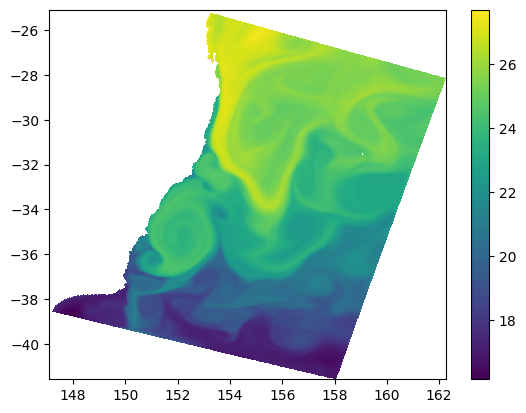

In [14]:
# Particle locations and initial time
npart = 1  # number of particles to be released
lon = 152
lat = -35
time = ocean_time[0]


SampleParticle = parcels.JITParticle.add_variable("temperature")

def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.temp[time, particle.depth, particle.lat, particle.lon]


pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=SampleParticle, lon=lon, lat=lat, time=time
)

output_file = pset.ParticleFile(name="SampleTemp.zarr", outputdt=timedelta(hours=1))

pset.execute(
    [parcels.AdvectionRK4, SampleT],
    runtime=timedelta(days=20),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in SampleTemp.zarr.
100%|██████████| 1728000.0/1728000.0 [00:40<00:00, 42734.58it/s]


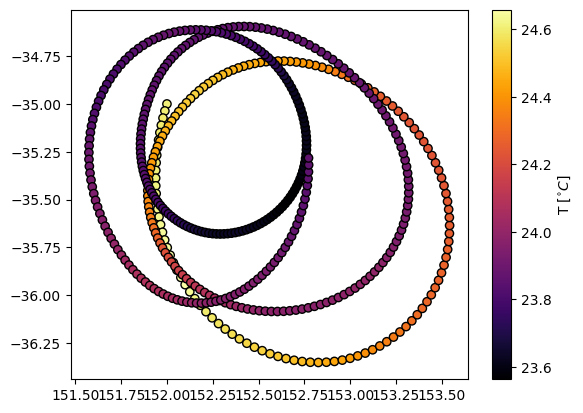

In [15]:
Particle_data = xr.open_zarr("SampleTemp.zarr")

plt.figure()
ax = plt.axes()

ax.plot(Particle_data.lon.transpose(), Particle_data.lat.transpose(), c="k", zorder=1)
T_scatter = ax.scatter(
    Particle_data.lon,
    Particle_data.lat,
    c=Particle_data.temperature,
    cmap=plt.cm.inferno,
    edgecolor="k",
    zorder=2,
)
plt.colorbar(T_scatter, label=r"T [$^{\circ} C$]")
plt.show()

In [222]:
import zarr

# Open the Zarr file
zarr_file = zarr.open("SampleTemp.zarr", mode='r')

# Access the data
temperature_data = zarr_file['temperature'][:]

# Print or process the data as needed
# print(temperature_data)

## 2D LADV

In [1]:
import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lat_rho  = dataset.variables['lat_rho'][:]
temp = np.load('/srv/scratch/z5297792/Climatology/temps/temp_01461.npy')
temp = np.transpose(temp,axes=(3,2,1,0))
u = np.load('/srv/scratch/z5297792/Climatology/u_v/u_01461.npy')
u = np.transpose(u,axes=(3,2,1,0))
v = np.load('/srv/scratch/z5297792/Climatology/u_v/v_01461.npy')
v = np.transpose(v,axes=(3,2,1,0))
vort = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_01461.npy')
vort = np.transpose(vort,axes=(3,2,1,0))
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, axes=(0,2,1))
ocean_time = dataset.variables['ocean_time'][:]

In [2]:
DEPTH_LVL = 15

u_lvl = u[:,DEPTH_LVL,:,:]
v_lvl = v[:,DEPTH_LVL,:,:]
vort_lvl = vort[:,DEPTH_LVL,:,:]

data = {
    "U": u_lvl,
    "V": v_lvl,
    "temp": vort_lvl
}
dims = {
    "lon": lon_rho,
    "lat": lat_rho,
    'time': ocean_time
}

fieldset = parcels.FieldSet.from_data(data, dims, mesh="spherical", allow_time_extrapolation=True,)

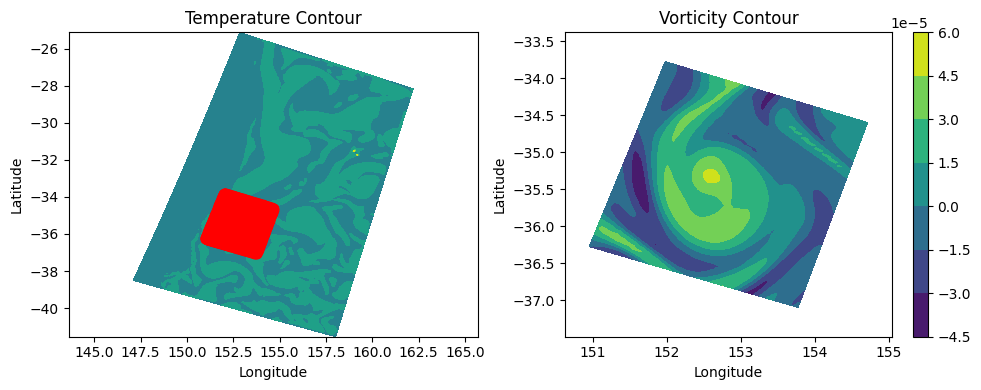

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Assuming `fieldset` and other required variables are already defined

# Set up the figure and axis objects for subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Contourf and Scatter
axs[0].contourf(fieldset.U.lon, fieldset.U.lat, fieldset.temp.data[0, :, :])
axs[0].set_title('Temperature Contour')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].axis('equal')

ii = list(range(90, 180))
jj = list(range(70, 130))

i = ii  # [::10]
j = jj  # [::10]

i, j = np.meshgrid(i, j)
ii, jj = np.meshgrid(ii, jj)

lon = lon_rho[j, i]
lat = lat_rho[j, i]

axs[0].scatter(lon, lat, color='r')

# Plot 2: Contourf of vorticity level
contour_plot = axs[1].contourf(lon_rho[j, i], lat_rho[j, i], vort_lvl[0, j, i])
axs[1].set_title('Vorticity Contour')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].axis('equal')
fig.colorbar(contour_plot, ax=axs[1])

# Show the plots
plt.tight_layout()
plt.show()


In [4]:
SampleParticle = parcels.JITParticle.add_variable("temperature")
def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.temp[time, particle.depth, particle.lat, particle.lon]
pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=SampleParticle, lon=lon, lat=lat, time=ocean_time[0]
)
output_file = pset.ParticleFile(name="SampleTemp.zarr", outputdt=timedelta(hours=1))
DAYS = 10
pset.execute(
    [parcels.AdvectionRK4, SampleT],
    runtime=timedelta(days=DAYS),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in SampleTemp.zarr.
100%|██████████| 864000.0/864000.0 [00:41<00:00, 20735.51it/s]


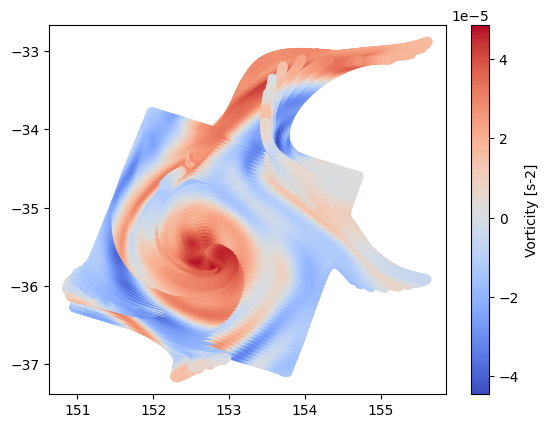

In [5]:
Particle_data = xr.open_zarr("SampleTemp.zarr")

plt.figure()
ax = plt.axes()

ax.plot(Particle_data.lon.transpose(), Particle_data.lat.transpose(), c="k", zorder=1)
T_scatter = ax.scatter(
    Particle_data.lon,
    Particle_data.lat,
    c=Particle_data.temperature,
    cmap=plt.cm.coolwarm,
    zorder=2,
)
plt.colorbar(T_scatter, label=r"Vorticity [s-2]")
plt.show()

In [8]:
import zarr
zarr_file = zarr.open("SampleTemp.zarr", mode='r')
vort_data = zarr_file['temperature'][:]

vort_lvl_means = []
for t in range(DAYS):
    vort_lvl_means.append(np.mean(vort_lvl[t, jj, ii]))

# Interpolation for daily average vorticity
minutes_per_day = 24 * 60
total_minutes = DAYS * minutes_per_day
avg_per_day = vort_lvl_means
daily_times = np.linspace(0, DAYS, len(avg_per_day))
new_times = np.arange(0, DAYS, 1/24)
interpolator = interp1d(daily_times, avg_per_day, kind='linear', fill_value='extrapolate')
interpolated_vort_means = interpolator(new_times)

IVD = np.abs(vort_data - interpolated_vort_means)

def vector_to_matrix(vector, a, b):
    matrix = np.reshape(vector, (a, b))
    return matrix

a, b = i.shape
LAVD = abs(vector_to_matrix(np.mean(IVD,axis=1), a, b))

LAV = abs(vector_to_matrix(np.mean(vort_data,axis=1), a, b))

In [14]:
def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

def matrix_range(matrix):
    return np.max(matrix) - np.min(matrix)

from scipy.spatial import ConvexHull
from shapely.geometry import Point, Polygon
def IsContourConvex(xt, yt, DeficiencyThresh):
    points = list(zip(xt, yt))
    hull = ConvexHull(points, qhull_options='QJ')
    HullArea = hull.volume  # In 2D, volume is the area
    polygon = Polygon(points)
    Area = polygon.area
    AreaDeficiency = abs(HullArea - Area) / Area * 100
    return AreaDeficiency <= DeficiencyThresh

def IsContourClosed(xt, yt):
    return len(xt) >= 3 and len(yt) >= 3 and xt[0] == xt[-1] and yt[0] == yt[-1]

def is_point_inside_contour(x_coords, y_coords, px, py):
    contour = Polygon(zip(x_coords, y_coords))
    point = Point(px, py)
    return contour.contains(point)

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def find_local_maxima(matrix):
    def is_local_maxima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_greater_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor > value
        if i > 0 and is_valid_and_greater_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_greater_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_greater_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_greater_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_greater_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_greater_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i + 1, j + 1]):
            return False
        return True
    i_max, j_max, value_max = [], [], []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_maxima(matrix, i, j):
                i_max.append(i)
                j_max.append(j)
                value_max.append(matrix[i, j])
    return i_max, j_max, value_max

def max_closed_convex_contour_finder(lon, lat, LAV, num_contours):
    i_global_max, j_global_max = find_global_maxima(LAV)
    xc_max = lon[i_global_max, j_global_max]
    yc_max = lat[i_global_max, j_global_max]
    data_range = matrix_range(LAV)
    largest_contour_xt = []
    largest_contour_yt = []
    for k in range(1, num_contours):
        level_to_extract = np.max(LAV) - k * data_range / num_contours
        c = plt.contour(lon, lat, LAV, levels=[level_to_extract], linewidths=1e-10, colors='k')
        xt, yt = extract_contour(level_to_extract, plot=c)
        if IsContourClosed(xt, yt) and IsContourConvex(xt, yt, DeficiencyThresh=10):
            if is_point_inside_contour(xt, yt, xc_max, yc_max):
                if len(xt) > len(largest_contour_xt):
                    largest_contour_xt, largest_contour_yt = xt, yt
    return largest_contour_xt, largest_contour_yt


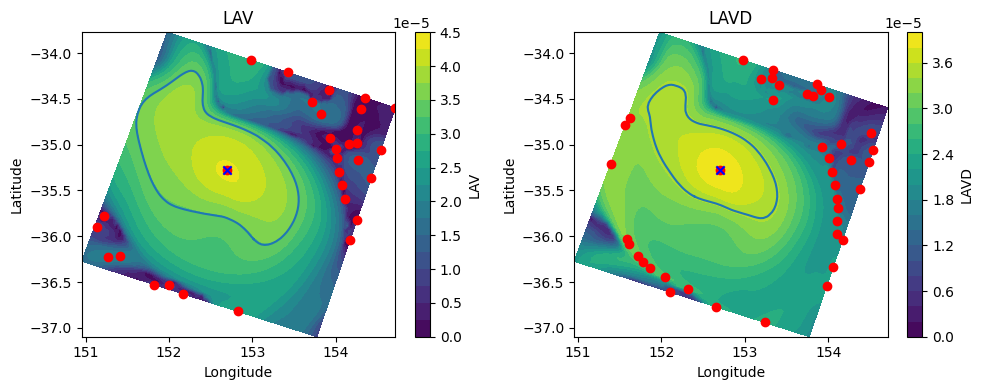

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

contourf_plot1 = ax1.contourf(lon, lat, LAV, levels=20, cmap='viridis')
fig.colorbar(contourf_plot1, ax=ax1, orientation='vertical', label='LAV')

##
xt, yt = max_closed_convex_contour_finder(lon, lat, LAV, num_contours=100)
ax1.plot(xt, yt)
##

i_local_max, j_local_max, _ = find_local_maxima(LAV)
ax1.scatter(lon[i_local_max, j_local_max], lat[i_local_max, j_local_max], color='red', marker='o', label='Local Maxima')
i_global_max, j_global_max = find_global_maxima(LAV)
lonc = lon[i_global_max, j_global_max]
latc = lat[i_global_max, j_global_max]
ax1.scatter(lonc, latc, color='blue', marker='x', label='Global Maxima')

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('LAV')
# ax1.legend()

contourf_plot2 = ax2.contourf(lon, lat, LAVD, levels=20, cmap='viridis')
fig.colorbar(contourf_plot2, ax=ax2, orientation='vertical', label='LAVD')

##
xt, yt = max_closed_convex_contour_finder(lon, lat, LAVD, num_contours=100)
ax2.plot(xt, yt)
##

i_local_max, j_local_max, _ = find_local_maxima(LAVD)
ax2.scatter(lon[i_local_max, j_local_max], lat[i_local_max, j_local_max], color='red', marker='o', label='Local Maxima')
i_global_max, j_global_max = find_global_maxima(LAVD)
lonc = lon[i_global_max, j_global_max]
latc = lat[i_global_max, j_global_max]
ax2.scatter(lonc, latc, color='blue', marker='x', label='Global Maxima')

ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('LAVD')
# ax2.legend()

plt.tight_layout()
plt.show()



## Eddies LAVD

In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [90]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000  # in meters
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c

def grid_finder(i_search, j_search, SEARCH_WIDTH):

    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho  = dataset.variables['lon_rho']
    lon_rho = np.transpose(lon_rho, axes=(1, 0))
    lat_rho  = dataset.variables['lat_rho']
    lat_rho = np.transpose(lat_rho, axes=(1, 0))

    i_left = 0
    i_right = 0
    j_down = 0
    j_up = 0
    while (i_search - i_left >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search - i_left, j_search], lon_rho[i_search - i_left, j_search])) < SEARCH_WIDTH/2:
        i_left += 1
    while (i_search + i_right < lon_rho.shape[0] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search + i_right, j_search], lon_rho[i_search + i_right, j_search])) < SEARCH_WIDTH/2:
        i_right += 1
    while (j_search - j_down >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search, j_search - j_down], lon_rho[i_search, j_search - j_down])) < SEARCH_WIDTH/2:
        j_down += 1
    while (j_search + j_up < lon_rho.shape[1] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search, j_search + j_up], lon_rho[i_search, j_search + j_up])) < SEARCH_WIDTH/2:
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_up = min(j_search + j_up, lon_rho.shape[1])
    j_down = max(j_search - j_down + 1, 0)

    I, J = np.meshgrid(np.arange(i_left, i_right), np.arange(j_down, j_up))

    return I, J
    
def eddies_nearest_rho(elon, elat):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho  = dataset.variables['lon_rho']
    lon_rho = np.transpose(lon_rho, axes=(1, 0))
    lat_rho  = dataset.variables['lat_rho']
    lat_rho = np.transpose(lat_rho, axes=(1, 0))
    R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
    i_search, j_search = np.argwhere(R == np.min(R))[0]
    return i_search, j_search

def vector_to_matrix(v, rows, cols):
    assert len(v) == rows * cols, "Vector length must match the desired matrix dimensions."
    mat = np.array(v).reshape(rows, cols)
    mat = np.flipud(mat)
    return mat
    

previous_file_idx = -1

In [91]:
import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lat_rho  = dataset.variables['lat_rho'][:]
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, axes=(0,2,1))

edata = eddies['Eddy22'].iloc[5]
t = extract_number(edata.name)

temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    
    fnumber = '0'+str(round(1461+ file_idx*30))
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_'+fnumber+'.nc'
    dataset = nc.Dataset(fname)
    
    u = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    u = np.transpose(u,axes=(3,2,1,0))
    v = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    v = np.transpose(v,axes=(3,2,1,0))
    vort = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy')
    vort = np.transpose(vort,axes=(3,2,1,0))
    ocean_time = dataset.variables['ocean_time'][:]
    temp = np.load('/srv/scratch/z5297792/Climatology/temps/temp_'+fnumber+'.npy') - np.repeat(temp_ave[:, :, :, np.newaxis], 30, axis=3)
    temp = np.transpose(temp,axes=(3,2,1,0))

    previous_file_idx = file_idx

vort = temp

In [94]:
DEPTH_LVL = 5

u_lvl = u[:,DEPTH_LVL,:,:]
v_lvl = v[:,DEPTH_LVL,:,:]
vort_lvl = vort[:,DEPTH_LVL,:,:]

data = {
    "U": u_lvl,
    "V": v_lvl,
    "temp": vort_lvl
}
dims = {
    "lon": lon_rho,
    "lat": lat_rho,
    'time': ocean_time
}

fieldset = parcels.FieldSet.from_data(data, dims, mesh="spherical", allow_time_extrapolation=True,)

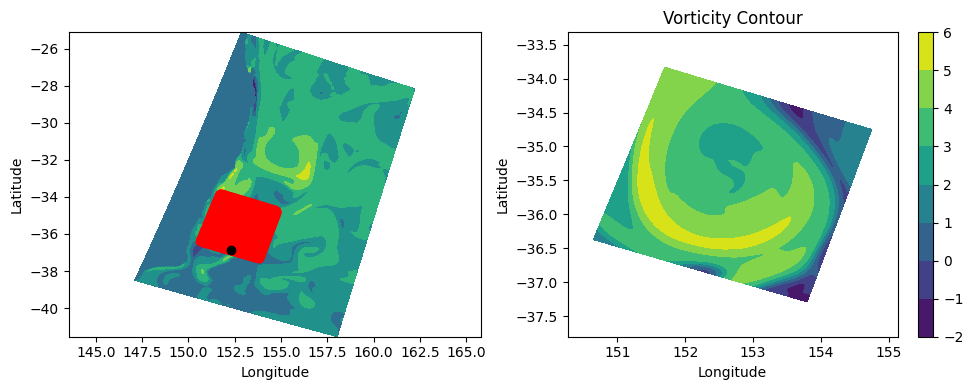

In [95]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

SEARCH_WIDTH = 300000

i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
I, J = grid_finder(i_search, j_search, SEARCH_WIDTH)

lon = lon_rho[J, I]
lat = lat_rho[J, I]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# Plot 1: Contourf and Scatter
axs[0].contourf(fieldset.U.lon, fieldset.U.lat, fieldset.temp.data[t_mod, :, :])
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].axis('equal')
axs[0].scatter(lon, lat, color='r')
axs[0].scatter(lon.flatten()[60], lat.flatten()[60], color='k')

# for i, txt in enumerate(daydic['Day6'].index):
#     axs[0].text(daydic['Day6'].Lon[i], daydic['Day6'].Lat[i], txt)

# Plot 2: Contourf of vorticity level
contour_plot = axs[1].contourf(lon, lat, vort_lvl[t_mod, J, I])
axs[1].set_title('Vorticity Contour')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].axis('equal')
fig.colorbar(contour_plot, ax=axs[1])

plt.tight_layout()
plt.show()


In [96]:
SampleParticle = parcels.JITParticle.add_variable("temperature")
def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.temp[time, particle.depth, particle.lat, particle.lon]
pset = parcels.ParticleSet(
    fieldset=fieldset, pclass=SampleParticle, lon=lon.flatten(), lat=lat.flatten(), time=ocean_time[0]
)
output_file = pset.ParticleFile(name="SampleTemp.zarr", outputdt=timedelta(hours=1))
DAYS = 4
pset.execute(
    [parcels.AdvectionRK4, SampleT],
    runtime=timedelta(days=DAYS),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in SampleTemp.zarr.
100%|██████████| 345600.0/345600.0 [00:12<00:00, 28587.45it/s]


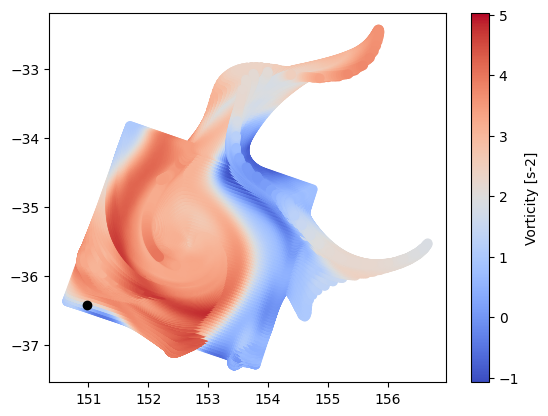

In [97]:
Particle_data = xr.open_zarr("SampleTemp.zarr")

plt.figure()
ax = plt.axes()

ax.plot(Particle_data.lon.transpose(), Particle_data.lat.transpose(), c="k", zorder=1)
T_scatter = ax.scatter(
    Particle_data.lon,
    Particle_data.lat,
    c=Particle_data.temperature,
    cmap=plt.cm.coolwarm,
    zorder=2,
)

plt.plot(pset.lon[0], pset.lat[0], "ko")

plt.colorbar(T_scatter, label=r"Vorticity [s-2]")
plt.show()

In [98]:
import zarr
zarr_file = zarr.open("SampleTemp.zarr", mode='r')
vort_data = zarr_file['temperature'][:]

In [99]:
Curlz_t = np.transpose(vort_data, axes=(1,0))
tspan = np.linspace(ocean_time[0],ocean_time[DAYS-1],DAYS*24)

In [102]:
Curlz_t.shape

(96, 6161)

In [103]:
Curlz_avg_t.shape

(96,)

In [104]:
Curlz_t[0,:].shape

(6161,)

In [105]:
I.shape

(61, 101)

In [121]:
vort_lvl_means = []
for t in range(DAYS):
    vort_lvl_means.append(np.mean(vort_lvl[t, J, I]))

minutes_per_day = 24 * 60
total_minutes = DAYS * minutes_per_day
avg_per_day = vort_lvl_means
daily_times = np.linspace(0, DAYS, len(avg_per_day))
new_times = np.arange(0, DAYS, 1/24)
interpolator = interp1d(daily_times, avg_per_day, kind='linear', fill_value='extrapolate')
interpolated_vort_means = interpolator(new_times)
Curlz_avg_t = interpolated_vort_means

In [107]:
IVD

array([1.7280366, 1.6692942, 1.6160142, ..., 2.1720867, 2.0705826,
       1.9649266], dtype=float32)

In [128]:
# Curlz_avg_t = np.mean(Curlz_t, axis=1)
IVD = np.abs(Curlz_t[0,:] - Curlz_avg_t[0])

fill = np.abs(Curlz_t)# - Curlz_avg_t[:, np.newaxis])

# LAVD = np.mean(fill, axis=0)

LAVD = []
for p in range(fill.shape[1]):
    LAVD.append(np.trapezoid(fill[:,p], tspan))

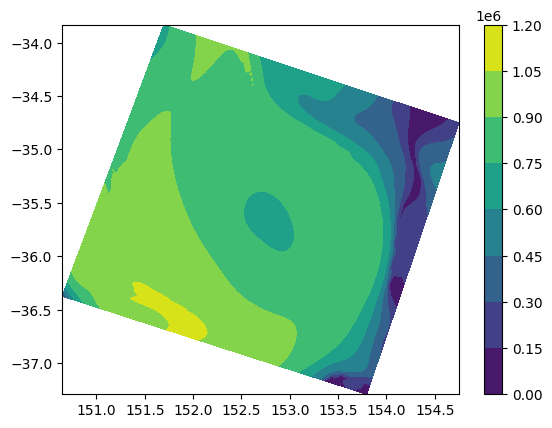

In [133]:
a, b = I.shape
dat = np.reshape(LAVD, (a, b))
plt.contourf(lon, lat, dat)
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(lon, lat, dat, cmap='viridis')
# fig.colorbar(surf)
plt.colorbar()

In [8]:
import zarr
zarr_file = zarr.open("SampleTemp.zarr", mode='r')
vort_data = zarr_file['temperature'][:]

# vort_lvl_means = []
# for t in range(DAYS):
#     vort_lvl_means.append(np.mean(vort_lvl[t, J, I]))

# Interpolation for daily average vorticity
# minutes_per_day = 24 * 60
# total_minutes = DAYS * minutes_per_day
# avg_per_day = vort_lvl_means
# daily_times = np.linspace(0, DAYS, len(avg_per_day))
# new_times = np.arange(0, DAYS, 1/24)
# interpolator = interp1d(daily_times, avg_per_day, kind='linear', fill_value='extrapolate')
# interpolated_vort_means = interpolator(new_times)

interpolated_vort_means = np.mean(vort_data, axis=0)


IVD = np.abs(vort_data - interpolated_vort_means)

a, b = I.shape
LAVD = abs(vector_to_matrix(np.mean(IVD,axis=1), a, b))

LAV = abs(vector_to_matrix(np.mean(vort_data,axis=1), a, b))

In [12]:
IVD = np.abs(vort_data - interpolated_vort_means)
IVD.shape

(1581, 96)

In [9]:
def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

def matrix_range(matrix):
    return np.max(matrix) - np.min(matrix)

from scipy.spatial import ConvexHull
from shapely.geometry import Point, Polygon
def IsContourConvex(xt, yt, DeficiencyThresh):
    points = list(zip(xt, yt))
    hull = ConvexHull(points, qhull_options='QJ')
    HullArea = hull.volume  # In 2D, volume is the area
    polygon = Polygon(points)
    Area = polygon.area
    AreaDeficiency = abs(HullArea - Area) / Area * 100
    return AreaDeficiency <= DeficiencyThresh

def IsContourClosed(xt, yt):
    return len(xt) >= 3 and len(yt) >= 3 and xt[0] == xt[-1] and yt[0] == yt[-1]

def is_point_inside_contour(x_coords, y_coords, px, py):
    contour = Polygon(zip(x_coords, y_coords))
    point = Point(px, py)
    return contour.contains(point)

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def find_local_maxima(matrix):
    def is_local_maxima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_greater_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor > value
        if i > 0 and is_valid_and_greater_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_greater_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_greater_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_greater_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_greater_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_greater_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i + 1, j + 1]):
            return False
        return True
    i_max, j_max, value_max = [], [], []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_maxima(matrix, i, j):
                i_max.append(i)
                j_max.append(j)
                value_max.append(matrix[i, j])
    return i_max, j_max, value_max

def max_closed_convex_contour_finder(lon, lat, LAV, num_contours):
    i_global_max, j_global_max = find_global_maxima(LAV)
    xc_max = lon[i_global_max, j_global_max]
    yc_max = lat[i_global_max, j_global_max]
    data_range = matrix_range(LAV)
    largest_contour_xt = []
    largest_contour_yt = []
    for k in range(1, num_contours):
        level_to_extract = np.max(LAV) - k * data_range / num_contours
        c = plt.contour(lon, lat, LAV, levels=[level_to_extract], linewidths=1e-10, colors='k')
        xt, yt = extract_contour(level_to_extract, plot=c)
        if IsContourClosed(xt, yt) and IsContourConvex(xt, yt, DeficiencyThresh=10):
            if is_point_inside_contour(xt, yt, xc_max, yc_max):
                if len(xt) > len(largest_contour_xt):
                    largest_contour_xt, largest_contour_yt = xt, yt
    return largest_contour_xt, largest_contour_yt


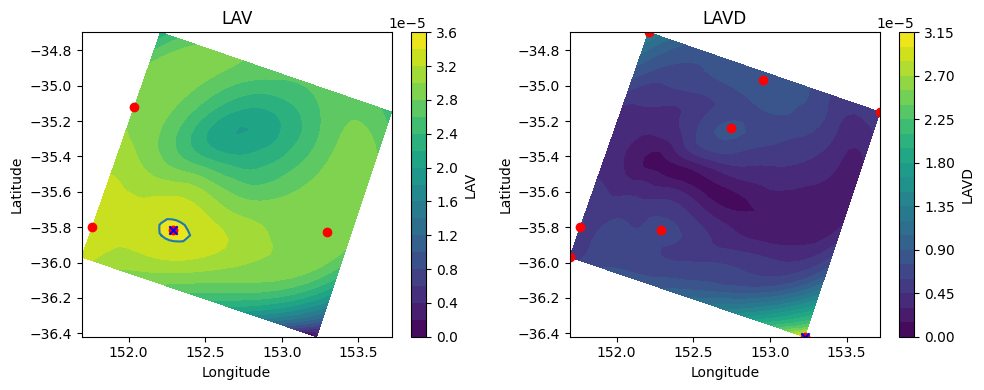

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

contourf_plot1 = ax1.contourf(lon, lat, LAV, levels=20, cmap='viridis')
fig.colorbar(contourf_plot1, ax=ax1, orientation='vertical', label='LAV')

##
xt, yt = max_closed_convex_contour_finder(lon, lat, LAV, num_contours=100)
ax1.plot(xt, yt)
##

i_local_max, j_local_max, _ = find_local_maxima(LAV)
ax1.scatter(lon[i_local_max, j_local_max], lat[i_local_max, j_local_max], color='red', marker='o', label='Local Maxima')
i_global_max, j_global_max = find_global_maxima(LAV)
lonc = lon[i_global_max, j_global_max]
latc = lat[i_global_max, j_global_max]
ax1.scatter(lonc, latc, color='blue', marker='x', label='Global Maxima')

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('LAV')
# ax1.legend()

contourf_plot2 = ax2.contourf(lon, lat, LAVD, levels=20, cmap='viridis')
fig.colorbar(contourf_plot2, ax=ax2, orientation='vertical', label='LAVD')

##
xt, yt = max_closed_convex_contour_finder(lon, lat, LAVD, num_contours=100)
ax2.plot(xt, yt)
##

i_local_max, j_local_max, _ = find_local_maxima(LAVD)
ax2.scatter(lon[i_local_max, j_local_max], lat[i_local_max, j_local_max], color='red', marker='o', label='Local Maxima')
i_global_max, j_global_max = find_global_maxima(LAVD)
lonc = lon[i_global_max, j_global_max]
latc = lat[i_global_max, j_global_max]
ax2.scatter(lonc, latc, color='blue', marker='x', label='Global Maxima')

ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('LAVD')
# ax2.legend()

plt.tight_layout()
plt.show()
